![alt text](https://cdn-images-1.medium.com/max/1200/1*BmvPfSSm2G8C-khX1rhCGg.png "Title")

# Lets generate some data to work with
We will use Faker library to generate random users with meaningful names, locations, emails and skills.  
Moreover we will do the same for projects

In [5]:
from random import choice, randint
from faker import Faker

# Amount of users and projects
USERS_NUM = 1000
PROJECTS_NUM = 100

fake = Faker()

skills = [
    'python',
    'angular',
    'backend',
    'django',
    'storytelling',
    'java',
    'marketing',
    'hardware',
    'design'
]

user_docs = []
for _ in range(USERS_NUM):
    profile = fake.simple_profile()
    user_docs.append({
        'name': profile['name'],
        'birthday': profile['birthdate'],
        'location': profile['address'],
        'email': profile['mail'],
        'skills': [choice(skills) for _ in range(randint(1, 5))],
    })

project_docs = []
for _ in range(PROJECTS_NUM):
    project_docs.append({
        'name': fake.company(),
        'description': fake.catch_phrase(),
        'tags': fake.words(),
        'creation_date': fake.date(),
        'founder': choice(user_docs)['name'],
        'cofounders': [choice(user_docs)['name'], choice(user_docs)['name']],
        'performers': [],
        'required_investment': fake.pyint(),
    })

### Now lets connect to Elasticsearch node

In [8]:
from elasticsearch import Elasticsearch, helpers

# Connect to  elasticsearch node
es = Elasticsearch([{'host':'localhost','port':9200}])

### Clean up the database to make sure that it is empty

In [19]:
es.indices.delete('user')
es.indices.delete('project')

{'acknowledged': True}

### And finally add our data to database

In [20]:
# Add users
helpers.bulk(es, [{
    '_index': 'user',
    '_type': '_doc',
    '_source': source,
} for source in user_docs])

# Add projects
helpers.bulk(es, [{
    '_index': 'project',
    '_type': '_doc',
    '_source': source,
} for source in project_docs])

es.indices.refresh(index='user')
es.indices.refresh(index='project')

{'_shards': {'total': 10, 'successful': 5, 'failed': 0}}

# Now lets make some queries to our dataset and show the result
We are also going to use matplotlib to show data distribution and some graphs

### Lets look at user age distribution among 3 groups

In [21]:
query_under_30 = list(helpers.scan(
    es,
    index='user',
    query={'query': {'range': {'birthday': {'gte':'now-30y/y'}} }},
))

query_under_50 = list(helpers.scan(
    es,
    index='user',
    query={'query': {'range': {'birthday': {'lt':'now-30y/y', 'gte':'now-50y/y'}} }},
 
))

query_older_than_50 = list(helpers.scan(
    es,
    index='user',
    query={'query': {'range': {'birthday': {'lt':'now-50y/y'}} }},
))

people_under_30 = [v['_source'] for v in query_under_30]
people_under_50 = [v['_source'] for v in query_under_50]
people_older_than_50 = [v['_source'] for v in query_older_than_50]

### Lets plot retrieved data

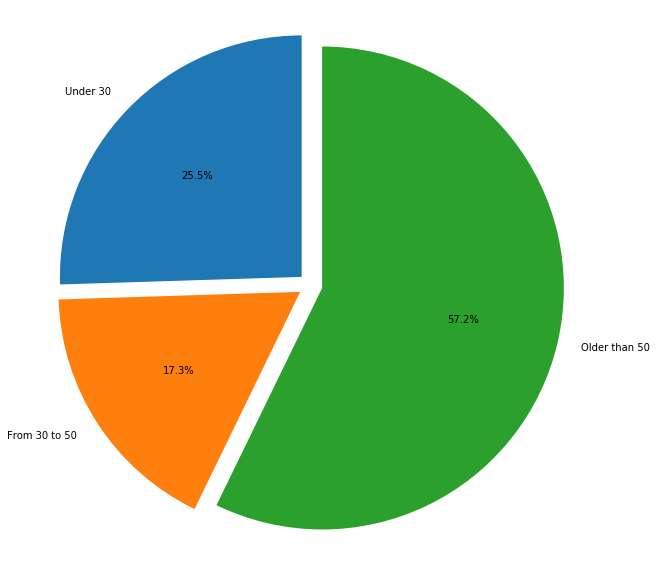

In [22]:
from matplotlib import pyplot as plt

labels = ['Under 30', 'From 30 to 50', 'Older than 50']
sizes = [len(people_under_30), len(people_under_50), len(people_older_than_50)]
explode = [0.05, 0.05, 0.05]

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,1,1)

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)

ax1.axis('equal')
plt.show()

### Now look at skills distribution among skills using elasticsearch querry

In [23]:
skills_dist = {}
for skill in skills:
    skills_dist[skill] = len(list(helpers.scan(
        es,
        index='user',
        query={'query': {'match': {'skills': skill}}},
    )))

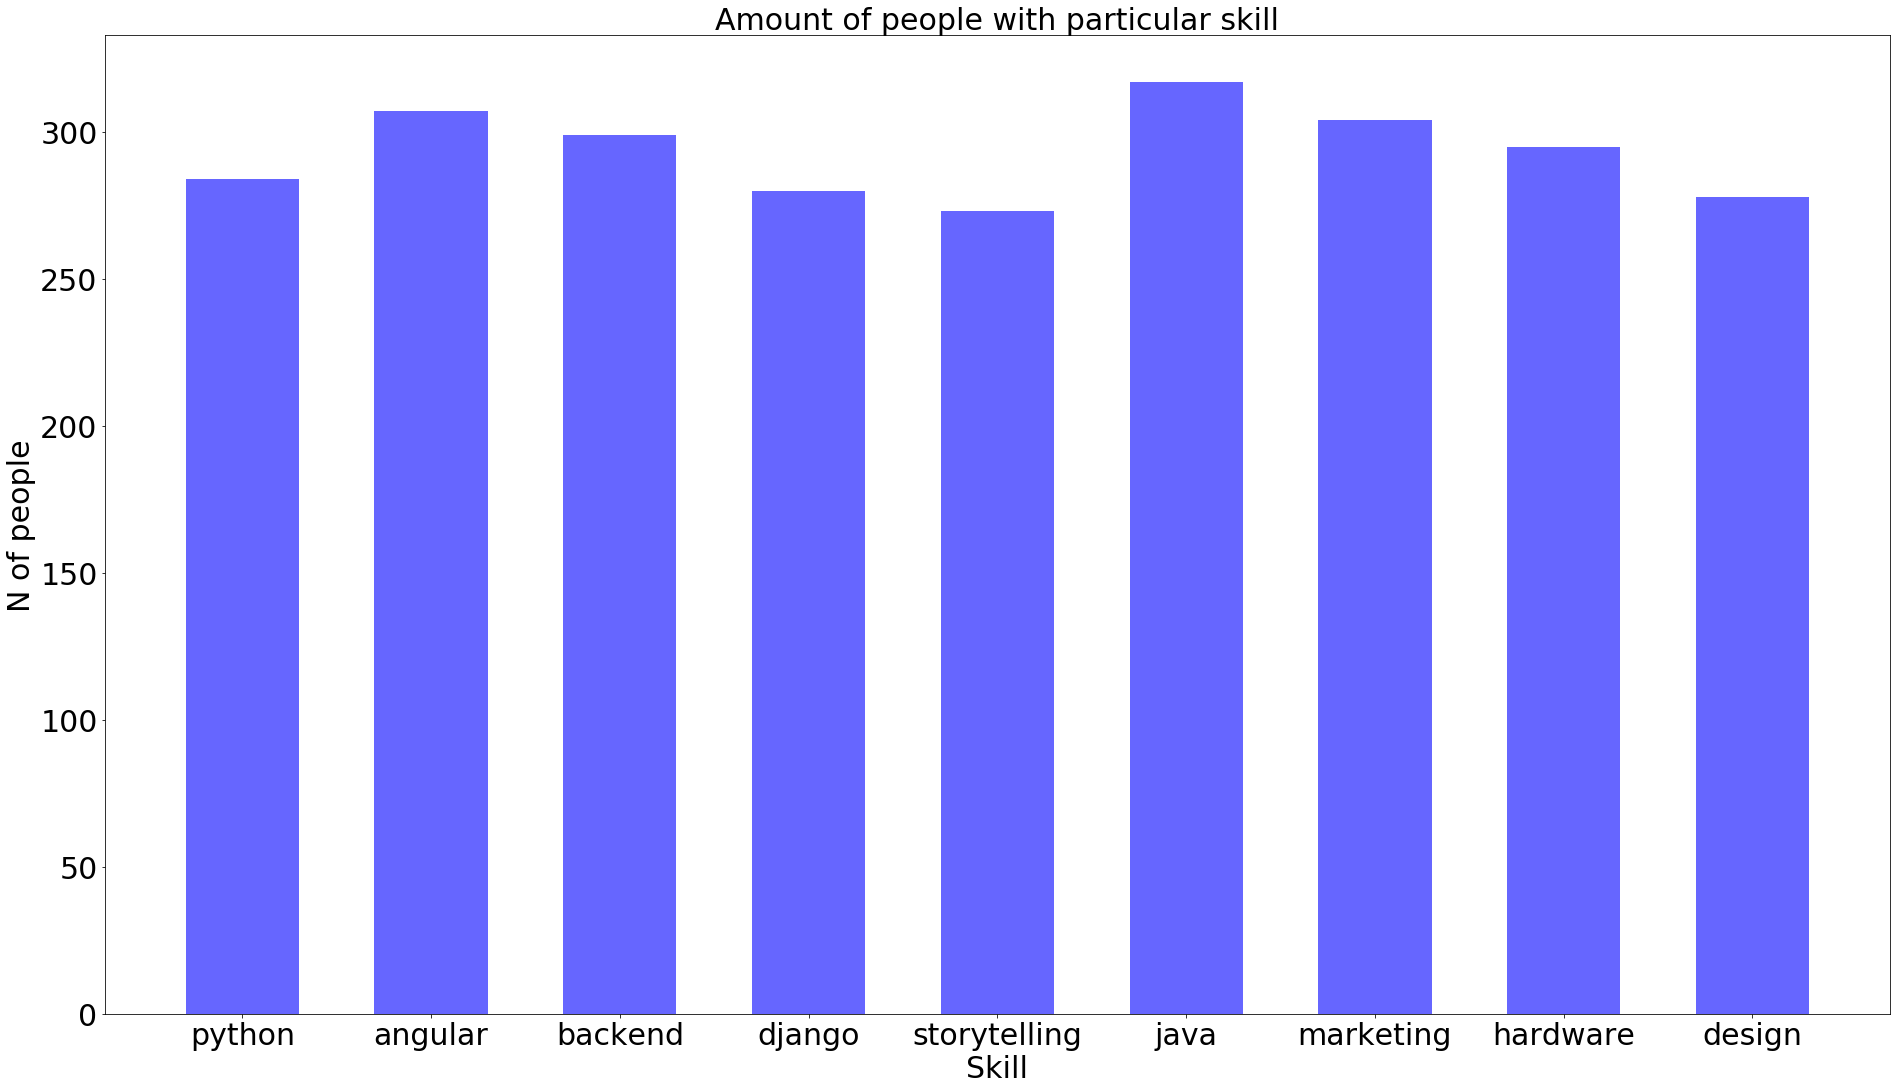

In [24]:
n_groups = len(skills)
values = skills_dist.values()

fig = plt.figure(figsize=(32,18))
ax = fig.add_subplot(1,1,1)


index = list(range(n_groups))
bar_width = 0.6
opacity = 0.6

# Generate bar
bar_1 = ax.bar(index, values, bar_width,
                alpha=opacity, color='b'
               )

# Name the axis
ax.set_xlabel('Skill')
ax.set_ylabel('N of people')
ax.set_title('Amount of people with particular skill')

# Name the bars
ax.set_xticks([i for i in index])
ax.set_xticklabels(skills_dist.keys())

# Make font bigger
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)

plt.show()

# Also there are importance of some features that we can controll
For example lets find all 'John' in our database and meke name more important than location

In [25]:
import json

johns_query = es.search(
    index='user',
    body={'query': {'multi_match': {'query': 'john', 'fields': ['name^2', 'location']}}},
)

johns = johns_query['hits']['hits']
minified_johns = [({
    'name': v['_source']['name'],
    'location': v['_source']['location'],
    '_score': v['_score'],
}) for v in johns]

print(json.dumps(minified_johns[:5], indent=2))

[
  {
    "name": "John Brown",
    "location": "6987 James Course\nSouth Matthew, WV 26744",
    "_score": 8.949466
  },
  {
    "name": "John Maldonado",
    "location": "USCGC Stone\nFPO AP 99297",
    "_score": 8.050212
  },
  {
    "name": "John Perez",
    "location": "6918 Rose Lock\nLake Amybury, ME 36500",
    "_score": 8.050212
  },
  {
    "name": "John King",
    "location": "393 Cannon Mountain Suite 406\nJasonton, MD 32509",
    "_score": 8.050212
  },
  {
    "name": "John Craig",
    "location": "05333 Jorge Plains Suite 739\nLake Kevinside, CT 10029",
    "_score": 7.7576222
  }
]
